# Accerelating AI model-based predictions by certainty-informed under-sampling

In this notebook, I implement a simple use case of certainty estimation to accelerate model predictions by undersampling input images. The goal is to correctly classify images with the least amount of acquired pixels (undersampling). This approach is of high relevance in the field of MRI imaging, where traditional full-scan MRI is time-consuming. Fast and accurate MRI-based diagnostics is a key topic in MRI research and development, offering substantial benefits in two primary areas:

- Medical imaging, where faster scans reduce the time patients must remain still, minimizing discomfort, reducing motion artifacts, and promoting the broader adoption of MRI-based diagnostics.
- High-throughput industrial applications, such as recent AI-powered fast egg or food sample classification using accelerated MRI.

The most common strategy to accelerate MRI acquisition relies on undersampling—capturing only a fraction of the data points and reconstructing the full image using a neural network. This method greatly reduces the time required to obtain an MRI scan while preserving sufficient resolution. In the aforementioned applications, the reconstructed scan can be used for tasks such as diagnosing a specific type of brain tumor or determining the sex of an embryo in an egg. However, not every pixel in an MRI scan is important for classification, meaning a significant portion of time is still spent acquiring data that is irrelevant for the downstream task.

A way to deal with this issue is to estimate the certainty of classifier predictions during the image acquisition process. In this notebook I implement its simpler form, which allows early stopping of image acquisition once a given prediction certainty is reached. In this method, new image content is randomly acquired. A more elaborate approach would enable classification certainty-guided acquisition paths, trained, for example, by reinforcement learning.

In [ ]:
# Install required packages
!pip install h5py
!pip install imblearn

In [2]:
work_path = "/dss/dsshome1/lxc0B/di29let/ondemand/Projects/Repositories/certainty-estimator"
import torch
import os
import sys
import h5py as h5
import numpy as np
sys.path.append(work_path)
from utils.test import load_model, train_estimators, get_estimator_accuracy
from utils.datasets import MRI_dataset, make_masked_testset
from utils.estimator_mix import LogisticRegressionMix, train_estimator_mix
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## Train certainty estimators
I will test the certainty estimators already explored in other notebooks, based on CNN dropout of high-level features,  on the global data or as a mixtures of masking level-specific estimators.

In [ ]:
fraction_levels = np.arange(0,0.97,0.05)
dropouts = [0.02]
drop_names = ['002']

# Train global estimators
estimate = train_estimators(drop_names,C=[1,0.02])

# Train mixture estimators 
estimate_mix = train_estimator_mix(fraction_levels, drop_names, C=[1,0.02])

## Generate undersampled data
Here I adapt the code that I have used to generate masked images. The main modification is that masking is done incrementally, such that the new pixel blocks are revealed only on hidden parts of the image.

First I change the image masking function, such that if a previous mask is provided, the new revealed blocks don't overlap with the already visible parts of the image.

In [7]:
import time
import itertools

dev = torch.device('cuda:0')

def random_zero_mask(image, dev, fraction, reduction, mask_or=None):
    """
    Create a random mask where a fraction of pixels are set to zero and apply it to the input image.

    Args:
        image (torch.Tensor): Input image tensor with shape (height, width).
        dev (torch.device): The device to store the mask (e.g., 'cuda' or 'cpu').
        fraction (float): Fraction of pixels to set to zero.
        reduction (int): Factor by which the mask is reduced in size before being resized, the 
                         bigger the reduction the bigger will be the masking blocks.
        mask_or (Optional[np.ndarray]): Optional pre-existing mask as a NumPy array, 
                                        if provided, the random mask will build on top of this.

    Returns:
        torch.Tensor: Image tensor with a random mask applied.
        torch.Tensor: The generated reduced mask tensor.
    """

    # Initialize mask_or if not provided
    if mask_or is None:
        mask_or = np.zeros((int(512 / reduction), int(512 / reduction)))
    else:
        mask_or = mask_or.cpu().numpy()

    # Get all possible coordinates for the mask
    coordinates = np.array(list(itertools.product(range(mask_or.shape[0]), range(mask_or.shape[1]))))

    # Determine which coordinates are already occupied
    occupied = np.apply_along_axis(lambda x: mask_or[x[0], x[1]], 1, coordinates)

    # Calculate how many new pixels to set
    new_elements = int(np.round((1 - fraction) * coordinates.shape[0]) - np.sum(occupied == 1))
    new_coordinates = np.random.choice(np.where(occupied == 0)[0], size=new_elements, replace=False)

    # Get new mask coordinates
    new_inds = coordinates[new_coordinates, :]

    # Convert mask to a torch tensor
    mask = torch.tensor(mask_or, device=dev)

    # Set the new coordinates to 1 in the mask
    for coord in new_inds:
        mask[coord[0], coord[1]] = 1

    # Define resizing transform
    resize_transform = transforms.Resize(
        (512, 512), 
        interpolation=transforms.InterpolationMode.NEAREST_EXACT, 
        antialias=False
    )

    # Apply the resizing transform to the mask
    mask_transformed = resize_transform(mask.unsqueeze(0))

    # Apply the mask to the input image
    masked_image = image * mask_transformed

    return masked_image, mask


Then I define a function to generate CNN features and predictions from undersampled images. Image masking is done sequentially populating the visible image blocks from fractions 0 to 0.95.

In [8]:
def generate_undersampled_data(sampling_fraction_range, dataset_generator, dataset_nr, dropout_p, 
                               reduction=32, mode=['hfeatures'], iterations=60, bsize=16, replicas=5):
    """
    Generate CNN features and predictions for undersampled data by applying random zero masks.

    Args:
        sampling_fraction_range (list): Range of sampling fractions to apply as corruption to the dataset.
        dataset_generator (callable): Function to generate the dataset.
        dataset_nr (int): Dataset identifier.
        dropout_p (float): Dropout probability to apply during prediction.
        reduction (int, optional): Reduction factor for the mask. Default is 32.
        mode (list, optional): List of modes for feature extraction (e.g., ['hfeatures', 'dropout']). Default is ['hfeatures'].
        iterations (int, optional): Number of iterations to run. Default is 60.
        bsize (int, optional): Batch size for the DataLoader. Default is 16.
        replicas (int, optional): Number of replicas to generate. Default is 5.

    Returns:
        dict: Dictionary containing feature tensors for each mode.
        dict: Dictionary containing error tensors (prediction mismatches) for each mode.
    """

    def prediction_features(sample):
        """
        Generate dropout-based prediction features.

        Args:
            sample (torch.Tensor): A batch of input images.

        Returns:
            torch.Tensor: Stacked dropout distribution quantiles for each class.
            torch.Tensor: Predicted class labels.
        """
        with torch.no_grad():
            if dropout_p == 0:
                mean_pred = net(sample)
                preds = torch.tile(mean_pred.unsqueeze(2), (50,))
            else:
                mean_pred, std_pred, preds = net.get_prediction_stats(sample, n_samples=50, batch_size=bsize)

        predict = torch.argmax(mean_pred, dim=1).to(dev)
        sort_pred = torch.sort(mean_pred, descending=True)

        # Calculate quantiles for the dropout distributions
        dist_qs = []
        for q in np.arange(0.02, 1, 0.02):
            for cl in range(3):
                dist_qs.append(torch.quantile(preds, q, dim=2)[np.arange(bsize), sort_pred[1][:, cl]])

        return torch.stack(dist_qs, dim=1), predict

    
    features = {}
    predict = {}
    
    wrong = {key: [] for key in mode}
    fts = {key: [] for key in mode}

    start = time.time()

    for k in range(replicas):
        # Generate dataset for this replica
        test_set = dataset_generator(0, dataset_nr)
        imageloader = iter(DataLoader(test_set, batch_size=bsize, drop_last=True))

        for i in range(iterations):
            print(i)
            try:
                sample = next(imageloader)

                # Initialize zero-masked sample tensor
                sample_masked = torch.zeros((sample[0].size(0), sample[0].size(1), sample[0].size(2), 
                                             sample[0].size(3), len(sampling_fraction_range)), device=dev)

                # Apply random zero mask for each sampling fraction
                for p in range(bsize):
                    for nl, corrup in enumerate(sampling_fraction_range):
                        if nl == 0:
                            sample_masked[p, 0, :, :, nl], mask = random_zero_mask(sample[0][p, 0, :, :], dev, corrup, reduction)
                        else:
                            sample_masked[p, 0, :, :, nl], mask = random_zero_mask(sample[0][p, 0, :, :], dev, corrup, reduction, mask_or=mask)

                # Extract features and predictions for each corruption level
                for nl, corrup in enumerate(sampling_fraction_range):
                    with torch.no_grad():
                        if 'hfeatures' in mode:
                            features['hfeatures'], prediction = net.get_features(sample_masked[:, :, :, :, nl])
                            predict['hfeatures'] = torch.argmax(prediction, dim=1)
                        if 'dropout' in mode:
                            features['dropout'], predict['dropout'] = prediction_features(sample_masked[:, :, :, :, nl])

                    # Store the features and error (wrong predictions) for each mode
                    for mode_name in mode:
                        if i == 0 and k == 0:
                            wrong[mode_name].append(torch.where(predict[mode_name] != sample[1].squeeze(), 1, 0))
                            fts[mode_name].append(features[mode_name])
                        else:
                            wrong[mode_name][nl] = torch.cat((wrong[mode_name][nl], 
                                                              torch.where(predict[mode_name] != sample[1].squeeze(), 1, 0)))
                            fts[mode_name][nl] = torch.cat((fts[mode_name][nl], features[mode_name]))

            except StopIteration:
                pass

    # Convert lists to tensors
    for mode_name in mode:
        wrong[mode_name] = torch.stack(wrong[mode_name]).cpu()
        fts[mode_name] = torch.stack(fts[mode_name]).cpu()

    end = time.time()
    print(f"Execution time: {end - start:.2f} seconds")

    return fts, wrong

Then I generate CNN outputs for undersampled images using the CNN trained with a dropout of 0.02, which proved to give the best certainty estimation in the certainty_estimators notebook.

In [ ]:
drop = 0.02
drop_name = '002'

sampling_levels = np.flipud(fraction_levels)

model_path = f"/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/dp_rate_{drop_name}_nonorm_masked_extendedtrain06/29_05_2024"
check_path = os.path.join(model_path,f"resnet18_epoc_20")
net, _ = load_model(check_path,dev,drop)
net.dropout.p = drop

fraction_levels = np.arange(0,0.97,0.05)
uncertainty_features = {key: {} for key in ['train','validation']}

def data_gen(fraction, dataset_nr):
    test_set = make_masked_testset(fraction,32, dataset_nr,dev=dev)
    return test_set
    
fts, wrong = generate_undersampled_data(sampling_levels,data_gen, 2, drop, mode=['hfeatures','dropout'],replicas=1,iterations=5)

#save data
data_path = '/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/tests'
torch.save(os.path.join(data_path,'undersamp_fts.pth'),fts)
torch.save(os.path.join(data_path,'undersamp_wrong.pth'),wrong)

In [ ]:
#load data if necessary
data_path = '/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/tests'
fts = torch.load(os.path.join(data_path,'undersamp_fts.pth'))
wrong = torch.load(os.path.join(data_path,'undersamp_wrong.pth'))

## Estimate certainty from CNN outputs
The next step is to get the certainty estimates of the different models based on the CNN classifier outputs obtained above.

In [10]:
estimator_type = ['dropout','hfeatures']

certainty_estimates = {key: [] for key in estimator_type}

for type in estimator_type:
    # For the mixture of estimators
    certainty_estimates[type].append(estimate_mix[type]['002']['clf'].predict_proba(fts[type]))

    # For the global estimators
    estim = np.zeros_like(certainty_estimates[type][0])
    for i,ft in enumerate(fts[type]):
        estim[i,:] = estimate[type]['002']['clf'].predict_proba(ft)[:,1]
        #certainty_estimates.append(estimate[type]['002']['clf'].predict_proba(fts[type].view(-1,fts[type].size(2))))
    certainty_estimates[type].append(estim)

Let's take a look at how the certainty changes as more parts of the image are revealed.

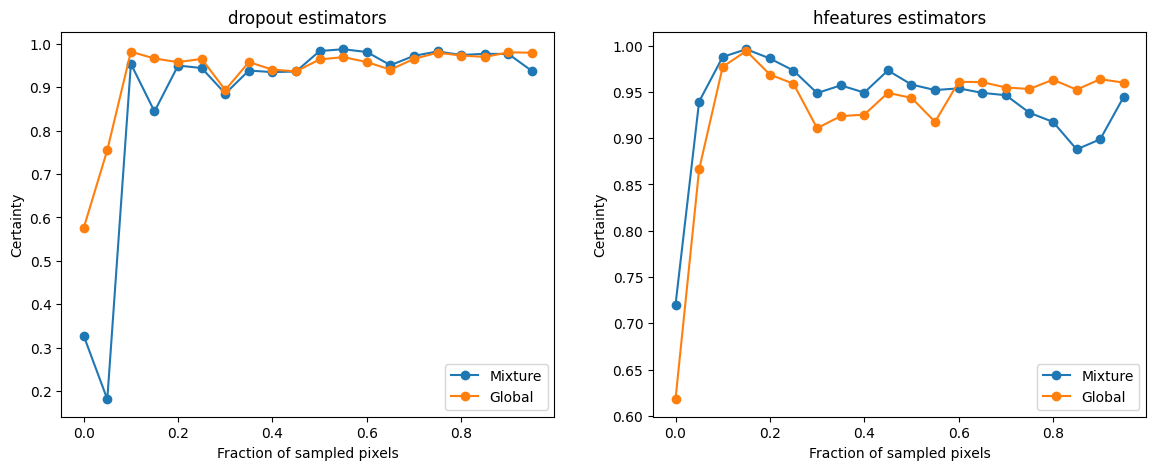

In [32]:
# Plot from example instance
exind = 37
sampling_plot = np.flipud(sampling_levels)
data_type = ['Mixture', 'Global']

fig, axs = plt.subplots(1,2,figsize=(14,5))

for i,type in enumerate(estimator_type):
    for p in range(2):
        axs[i].plot(sampling_plot,certainty_estimates[type][p][:,exind],'o-')
        axs[i].set(xlabel='Fraction of sampled pixels', ylabel='Certainty',title=f"{estimator_type[i]} estimators")
        axs[i].legend(data_type)

## Simulate an under-sampling scenario with early stopping guided by prediction certainty
In this section, I simulate a real world application where cummulative random sampling is stopped when the certainty of the model reaches a value above a given threshold. This early stopping avoids wasting unecessary time sampling pixels that won't significantly enhance accuracy.

The collected certainties contain the full range of sampled fractions of image, so to simulate early stopping I define a function that for each instance, finds the first sampling level where certainty exceeds a given threshold.

In [33]:
def find_sampling_points(certainty,thr):
    # Find the indices where certainty is above thr
    sp = np.where(certainty>thr)[0]

    # Deal with cases where certainty never reached thr
    if len(sp)==0:
        sp=19
    else:
        sp = sp[0]
    # if sp>19:
    #     sp=19
        
    return sp

Then I find the number of acquired pixel blocks in each instance, calculate the total acquired blocks from all instances and the overall accuracy on the classification task for multiple certainty thresholds. As a control, I compute the accuracy for each bin of sampling level.

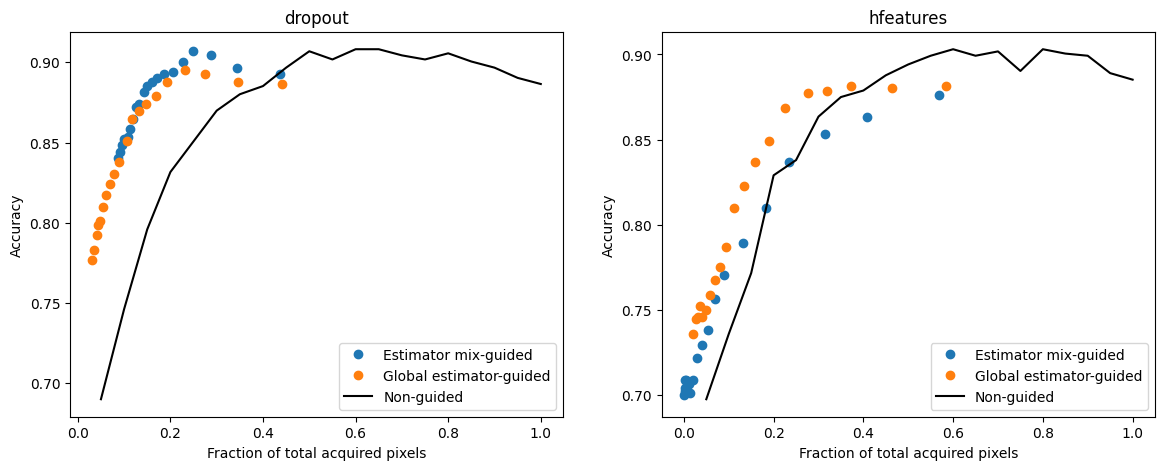

In [34]:
# Number of samples from the features
n_samples = fts['hfeatures'].size(1)

fig, axs = plt.subplots(1,2,figsize=(14,5))

# Define thresholds to test
certainty_thrs = np.arange(0.6,0.99,0.02)

# Loop over the estimator types for visualization
for ind,type in enumerate(estimator_type):

    for p in range(2):
        # Get certainties 
        certainty = certainty_estimates[type][p]

        # Calculate the fraction sampled and accuracy for each certainty threshold
        frac_sampled = []
        acc_sampled = []
        for cert in certainty_thrs:
            sampling_points = np.apply_along_axis(lambda x: find_sampling_points(x,cert),0,certainty)
            sampling_wrong = np.zeros((n_samples,1))
            
            for i,sampled in enumerate(sampling_points):
                sampling_wrong[i] = wrong[type][sampled,i]
            
            frac_sampled.append(np.sum(sampling_points)/(20*n_samples))
            acc_sampled.append(1-np.sum(sampling_wrong)/n_samples)

        # Control accuracy without guided sampling
        samp_control = 1-torch.sum(wrong[type],1)/n_samples

        # Plot the results
        axs[ind].plot(np.array(frac_sampled),np.array(acc_sampled),'o')
        
        if p==1:
            axs[ind].plot(1-np.flipud(fraction_levels),samp_control,color='black')
        axs[ind].set(xlabel='Fraction of total acquired pixels',ylabel='Accuracy',title=type)
        axs[ind].legend(["Estimator mix-guided", "Global estimator-guided","Non-guided"])
plt.show()

When using dropout-based estimators, the accuracy curves of certainty-guided undersampling are clearly shifted to the left, as compared with non-guided undersampling. Overall, the dropout-based estimator mix seems to give the best results. Noteworthy, the enhancement of accuracy at low sampling range is not so evident when using high-level feature-based estimators, in line with their lower performance in certainty estimation, shown in the certainty_estimators notebook.

## Conclusion
The results from this simulation of a simple certainty-guided undersampling method highlight the clear advantages of incorporating certainty estimation into AI model pipelines. I demonstrate that by halting a random image acquisition process once classification certainty reaches a predefined threshold, it is possible to significantly improve the trade-off between amount of acquired data and image classification accuracy. Further refinements are likely achieved by using more sophisticated algorithms, such as reinforcement learning, to guide image acquisition paths using certainty.

These techniques offer promising potential to further enhance the efficiency and throughput of MRI-based diagnostics in industrial applications.